# 🧊 Lab 7: Frozen Lake Revisited and Farewell

In this lab, we **return once more to the Frozen Lake** — now larger and more mysterious than before.  
This lab is designed to **tie everything together** through a focused review and practical reflection.


## 🎯 Learning Goals

- Revisit the **core ideas** of **Value Iteration (VI)** and **Policy Iteration (PI)**.  
- Understand how **Monte Carlo** and **Temporal-Difference (TD)** methods extend the same foundation to unknown environments.  
- Gain intuition for how **model-based** and **model-free** reinforcement learning relate.

In [22]:
import gymnasium as gym
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import random
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from util_frozen import *

In [23]:
# Define a smaller 3x3 map
DESC_5x5 = [
    "SFFFF",
    "FFHFF",
    "FHHFF",
    "FHHFF",
    "FFFFG",
]
env = gym.make("FrozenLake-v1",desc=DESC_5x5,is_slippery=True, render_mode="ansi")
obs, info = env.reset(seed=42)
print(env.render())


SFFFF
FFHFF
FHHFF
FHHFF
FFFFG



In [24]:
# Get the state transition matrix
P, R, absorbing, shape2d, flatmap = build_frozenlake_transitions(DESC_5x5, is_slippery=True)
T_per_action = [P[:, a, :] for a in range(4)] 
P_all = np.array([T_per_action[0], T_per_action[1], T_per_action[2], T_per_action[3]])

In [4]:
n_states = 25
Reward = np.zeros((n_states,), dtype = int) 
Reward[-1] = 1
gamma = 0.9

## 🗺️ Part 1 – Revisiting the Lake

First we re-implement the **value iteration** approach, which combines evaluation and 
improvement into a single update rule:

$$
V_{k+1}(s) \;=\; \max_a \Big[ R(s) + \gamma \sum_{s'} P(s'|s,a) \, V_k(s') \Big].
$$

Once the value function converges, we extract the optimal policy by choosing, 
in each state, the action that achieves the maximum:

$$
\pi^*(s) = \arg\max_a \Big[ R(s) + \gamma \sum_{s'} P(s'|s,a) V^*(s') \Big].
$$

In [5]:
# Initialize the original value 
V_0 = np.zeros_like(Reward, dtype=float)
V_new = np.zeros_like(V_0, dtype=float)
NUM_ITER = 150
NUM_ACT = P_all.shape[0]
for i_step in np.arange(NUM_ITER):
    for i_state in np.arange(n_states):
        action_values = np.zeros((4,), dtype=float)
        for i_action in np.arange(NUM_ACT):
            action_values[i_action] = gamma * np.sum(P_all[i_action][i_state] * V_0) + Reward[i_state]
        V_new[i_state] = np.max(action_values)
    V_0 = V_new
    if np.mod(i_step, 10) ==0:
        print(f"iter:{i_step}, values: {V_new}")

iter:0, values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
iter:10, values: [0.01 0.03 0.11 0.36 0.47 0.01 0.01 0.   0.73 1.01 0.03 0.   0.   1.43
 2.   0.11 0.   0.   2.51 3.74 0.35 0.75 1.72 3.74 6.86]
iter:20, values: [0.18 0.32 0.65 1.31 1.46 0.18 0.15 0.   1.81 2.17 0.29 0.   0.   2.72
 3.42 0.56 0.   0.   4.02 5.44 1.13 1.7  2.98 5.44 8.91]
iter:30, values: [0.39 0.57 0.97 1.75 1.91 0.37 0.28 0.   2.26 2.63 0.51 0.   0.   3.21
 3.94 0.86 0.   0.   4.57 6.05 1.53 2.12 3.47 6.05 9.62]
iter:40, values: [0.49 0.68 1.1  1.92 2.08 0.47 0.34 0.   2.42 2.8  0.61 0.   0.   3.39
 4.12 0.98 0.   0.   4.76 6.26 1.69 2.28 3.65 6.26 9.87]
iter:50, values: [0.53 0.72 1.15 1.97 2.13 0.51 0.37 0.   2.48 2.85 0.65 0.   0.   3.45
 4.19 1.03 0.   0.   4.83 6.33 1.74 2.33 3.71 6.33 9.95]
iter:60, values: [0.55 0.74 1.17 1.99 2.15 0.52 0.38 0.   2.5  2.87 0.67 0.   0.   3.47
 4.21 1.04 0.   0.   4.85 6.36 1.76 2.35 3.73 6.36 9.98]
iter:70, values: [0.55 0.74 1.17 2. 

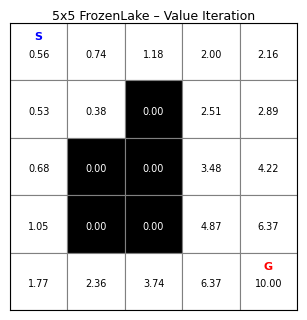

In [6]:
render_value_grid(V_new, DESC_5x5, title="5x5 FrozenLake – Value Iteration")

Next, we try to re-implement the **Truncated (Modified) Policy Iteration** algorithm, where we alternate between **partial policy evaluation** and **policy improvement**:

$$
V^{(j+1)}(s) \;=\; R(s) \;+\; \gamma \sum_{s'} P(s' \mid s, \pi_k(s))\, V^{(j)}(s'),
\quad j = 0,1,\dots,m-1,
$$

followed by:

$$
\pi_{k+1}(s) \;=\; \arg\max_{a} \Big[ \, R(s) \;+\; \gamma \sum_{s'} P(s' \mid s, a)\, V^{(m)}(s') \, \Big].
$$


In [7]:
# Initialize an original value 
V_0 = np.zeros_like(Reward, dtype=float)
V_new = np.zeros_like(V_0, dtype=float)
# Initialize an original policy 
PI_0 = np.zeros_like(Reward)
PI_new = np.zeros_like(Reward)
NUM_ITER = 40
NUM_ACT = P_all.shape[0]
NUM_PE = 10

for i_step in np.arange(NUM_ITER):
    for i_VI in np.arange(NUM_PE): 
        for i_state in np.arange(n_states):
            chosen_action = PI_0[i_state]
            V_new[i_state] = gamma * np.sum(P_all[chosen_action][i_state] * V_0) + Reward[i_state]
    for i_state in np.arange(n_states):
        action_values = np.zeros((4,), dtype=float)
        for i_action in np.arange(NUM_ACT):
            action_values[i_action] = gamma * np.sum(P_all[i_action][i_state] * V_new) + Reward[i_state]
        PI_new[i_state] = np.argmax(action_values)
    V_0 = V_new
    PI_0 = PI_new
    print(f"iter:{i_step}, values: {V_new}, policy: {PI_new}")

iter:0, values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.], policy: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
iter:1, values: [0.   0.   0.   0.03 0.12 0.   0.   0.   0.08 0.29 0.   0.   0.   0.26
 0.86 0.   0.   0.   0.84 2.46 0.   0.   0.   2.72 6.86], policy: [0 0 1 2 2 0 0 0 2 2 0 0 0 2 2 0 0 0 2 2 0 0 1 2 0]
iter:2, values: [0.   0.   0.23 0.85 0.91 0.   0.   0.   1.3  1.44 0.   0.   0.   2.21
 2.61 0.   0.   0.   3.64 4.84 0.   0.   2.2  5.28 8.91], policy: [0 1 2 2 2 0 0 0 2 1 0 0 0 2 1 0 0 0 2 1 0 1 1 2 0]
iter:3, values: [0.   0.21 0.67 1.65 1.82 0.   0.06 0.   2.2  2.58 0.   0.   0.   3.17
 3.91 0.   0.   0.   4.55 6.04 0.   1.32 3.12 6.04 9.62], policy: [1 2 3 2 2 1 0 0 2 1 0 0 0 2 1 0 0 0 2 1 1 1 1 2 0]
iter:4, values: [0.31 0.53 1.03 1.91 2.07 0.25 0.23 0.   2.42 2.79 0.41 0.   0.   3.38
 4.12 0.8  0.   0.   4.76 6.26 1.54 2.18 3.6  6.26 9.87], policy: [3 3 3 2 2 0 0 0 2 1 0 0 0 2 1 0 0 0 2 1 1 1 1 2 0]
iter:5, values: [0.51 0.7

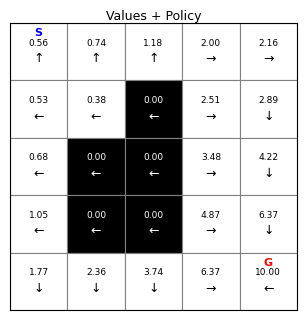

In [8]:
render_value_and_policy_grid(V_new, PI_new, DESC_5x5, title="Values + Policy")

# 🍀 Part 2 — Monte Carlo (MC) Control with $ε$-Greedy Policy


In this section we implement **Monte Carlo $ε$-Greedy Control**, a practical variant of **Monte Carlo Exploring Starts** that does **not** require special start states.

---

## 📘 Algorithm: MC ε-Greedy Control

**Goal:** Search for an optimal policy $π^*$ and action-value function $q^*$ through sampling and $ε$-greedy improvement.

### Initialization
- Initialize policy $\pi_0(a | s)$ and action-value function $q(s, a)$ for all $(s, a)$.  
- Initialize `R(s,a) = 0`, `N(s,a) = 0`.  
- Choose an exploration parameter $ε \in (0, 1]$.


In [9]:
import numpy as np

def epsilon_adjust_action(action, n_actions, epsilon):
    """
    With probability ε, replace the chosen action with a random one (exploration);
    otherwise keep the same action (exploitation).

    Parameters
    ----------
    action : int
        The greedy or proposed action.
    n_actions : int
        Total number of possible actions.
    epsilon : float
        Exploration probability (0 ≤ ε ≤ 1).

    Returns
    -------
    int : possibly adjusted action
    """
    if np.random.rand() < epsilon:
        # explore: choose any action except the current one (optional)
        alt_actions = [a for a in range(n_actions) if a != action]
        return np.random.choice(alt_actions)
    else:
        # exploit: keep the current action
        return action


In [10]:
import numpy as np

n_states = env.observation_space.n     # total number of states
n_actions = env.action_space.n         # total number of actions
# Action–value function q(s,a)
Q = np.zeros((n_states, n_actions), dtype=float)
Q[-1,:] =10
# Cumulative returns R(s,a)
Returns = np.zeros_like(Q, dtype=float)
# Visit counts N(s,a)
Num = np.zeros_like(Q, dtype=float)
min_epsilon = 0.1
epsilon_decay = 0.95
max_steps = 100
# Exploration parameter
epsilon = 1

# Deterministic greedy policy: one action per state
# Initially arbitrary since all Q=0
pi = np.zeros(n_states, dtype=int)

print("Initialization complete:")
print(f"States: {n_states}, Actions: {n_actions}, ε = {epsilon}")


Initialization complete:
States: 25, Actions: 4, ε = 1


### For each episode
1. **Episode Generation**  
   - Choose a starting state–action pair $(s_0, a_0)$ or simply start from the default start state.  
   - Follow the **current ε-greedy policy** $\pi$ to generate an episode of length $T$:  
     $ (s_0, a_0, r_1, s_1, a_1, \dots, s_{T-1}, a_{T-1}, r_T) $.
2. **Initialization for this episode:** $G = 0$

3. **Backward Return Computation**  
   For each step of the episode, $t = T − 1, T − 2, \ldots, 0$ we do the following:
   $$
   g \leftarrow \gamma g + r_{t+1}
   $$
   $$
   \text{R}(s_t, a_t) \leftarrow \text{R}(s_t, a_t) + g
   $$
   $$
   \text{N}(s_t, a_t) \leftarrow \text{N}(s_t, a_t) + 1
   $$
   $$
   q(s_t, a_t) \leftarrow \frac{\text{R}(s_t, a_t)}{\text{N}(s_t, a_t)}
   $$
4. **Policy Improvement**
   - Let $ a^* = \arg\max_a q(s_t, a) $.  
   - Update π to be $\epsilon$-greedy with respect to q:

     $$
     \pi(a|s_t) =
     \begin{cases}
     1 - \varepsilon + \dfrac{\varepsilon}{|\mathcal{A}(s_t)|}, & a = a^* \\
     \dfrac{\varepsilon}{|\mathcal{A}(s_t)|}, & a \neq a^*
     \end{cases}
     $$

iter: 0, epsilon = 0.1 


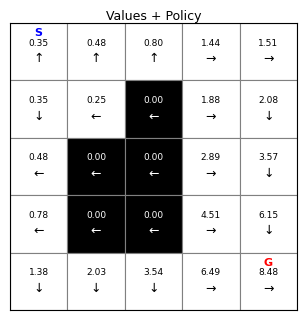

iter: 1, epsilon = 0.1 


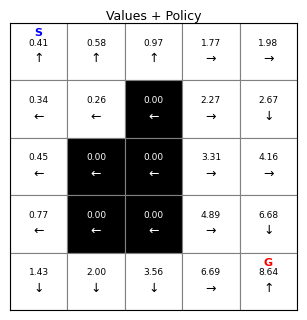

iter: 2, epsilon = 0.1 


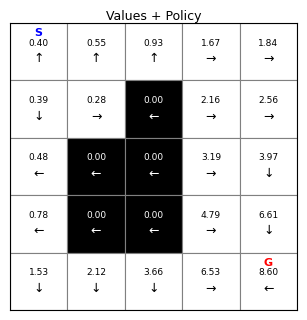

In [18]:
num_episodes = 20000  # Here, one episode is too short, we do multiple episodes

for i_ter in np.arange(3):
    Q        = np.zeros((n_states, n_actions), dtype=float)
    Returns  = np.zeros_like(Q)
    Num      = np.zeros_like(Q)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    for ep in range(num_episodes):
        s, _ = env.reset()
        states, actions, rewards = [s], [], []
        
        done, steps = False, 0
        while steps < max_steps:
            a = epsilon_adjust_action(pi[s], n_actions, epsilon)
            # a slight modification on the environment to make the result match
            if done:
                s_next = s 
                r = Reward[s]
                actions.append(a); rewards.append(r); states.append(s_next) 
            else: 
                s_next, r, term, trunc, _ = env.step(a)
                done = bool(term or trunc)
                actions.append(a); rewards.append(r); states.append(s_next)    
                s = s_next
            
            steps += 1
    
        # ---- Backward returns + updates (Every-visit) ----
        G = 0.0
        T = len(actions)
        for t in range(T-1, -1, -1):
            G = gamma * G + rewards[t]
            s_t, a_t = states[t], actions[t]
            Returns[s_t, a_t] += G
            Num[s_t, a_t]     += 1.0
            Q[s_t, a_t]        = Returns[s_t, a_t] / Num[s_t, a_t]

    pi = np.argmax(Q,axis=1)
    print(f"iter: {i_ter}, epsilon = {epsilon} ")
    render_value_and_policy_grid(Q.max(axis=1), pi, DESC_5x5, title="Values + Policy")

# 🍀 Part 3 —  🧩 SARSA (On-Policy TD Control)

This code implements the **SARSA** algorithm, an on-policy temporal-difference control method.  
At each step, the agent:
1. Chooses an action `a` using **ε-greedy(Q)**.  
2. Executes it, observes reward `r` and next state `s_next`.  
3. Selects the next action `a_next` from the same ε-greedy policy.  
4. Updates  
   $$
   Q[s,a] \leftarrow Q[s,a] + \alpha \big[r + \gamma Q[s',a'] - Q[s,a]\big].
   $$

The policy `pi` is gradually improved as  
`pi[s] = argmax(Q[s,:])`.  
Every few thousand episodes, the current **value map** and **policy grid** are rendered to show learning progress.


In [ ]:
alpha = 0.1
gamma = 0.9
epsilon = 1.0
min_epsilon = 0.1
epsilon_decay = 0.995
num_episodes = 50000
max_steps    = 100
Q = np.zeros((n_states, n_actions), dtype=float)
pi = np.zeros(n_states, dtype=int)

ep: 0, epsilon = 0.9950


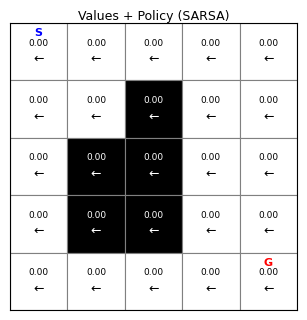

ep: 5000, epsilon = 0.9900


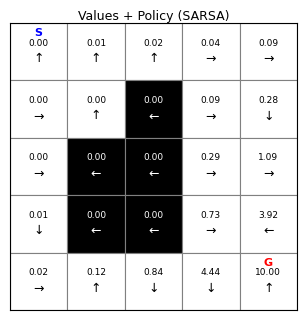

ep: 10000, epsilon = 0.9851


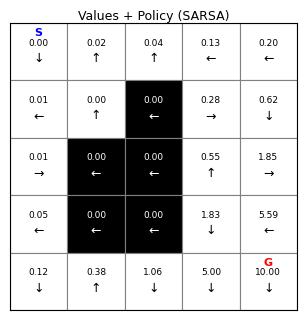

ep: 15000, epsilon = 0.9801


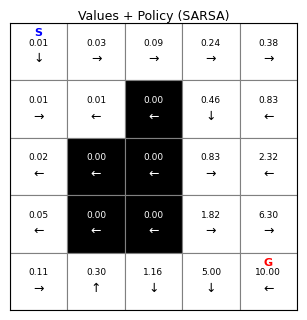

ep: 20000, epsilon = 0.9752


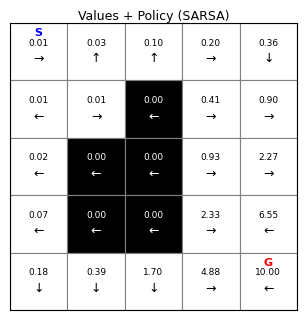

ep: 25000, epsilon = 0.9704


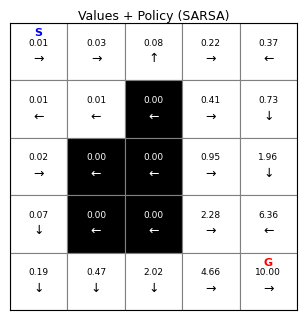

ep: 30000, epsilon = 0.9655


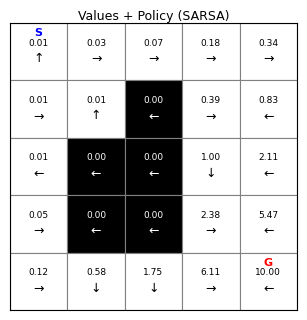

ep: 35000, epsilon = 0.9607


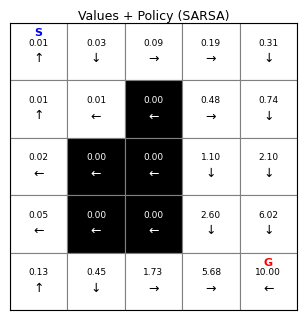

ep: 40000, epsilon = 0.9559


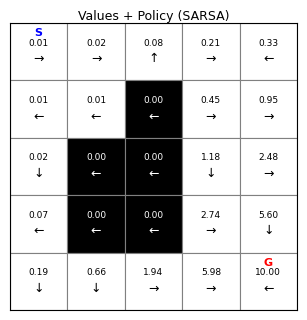

ep: 45000, epsilon = 0.9511


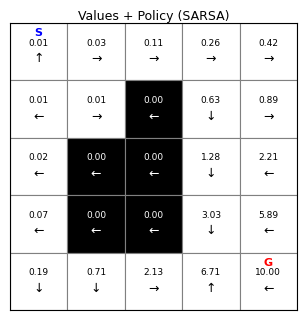

In [21]:
for i_ep in range(num_episodes):
    s, _ = env.reset()
    done = False

    a = epsilon_adjust_action(pi[s], n_actions, epsilon)

    for t in range(max_steps):
        if done:
            s_next = s
            r = Reward[s]
        else:
            s_next, r, term, trunc, _ = env.step(a)
            done = bool(term or trunc)
        
        a_next = epsilon_adjust_action(pi[s_next], n_actions, epsilon)
        td_target = r + gamma * Q[s_next, a_next]
        Q[s, a] += alpha * (td_target - Q[s, a])
        s, a = s_next, a_next
        pi[s] = np.argmax(Q[s])
        
    if i_ep % 5000 == 0:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        print(f"ep: {i_ep}, epsilon = {epsilon:.4f}")
        render_value_and_policy_grid(Q.max(axis=1), pi, DESC_5x5, title="Values + Policy (SARSA)")
